In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

# 1.Overview and Import Data

In [5]:
income = pd.read_excel("income.xls")
house1 = pd.read_csv("MELBOURNE_HOUSE_PRICES_LESS.csv")
house2 = pd.read_csv("Melbourne_housing_FULL.csv")

# 2. Income Data
## 2.1  Data Cleaning
把所有带东西南北的都放到同一个Suburb里。

In [6]:
income["SA2 NAME"]

0                      NaN
1                Alfredton
2                 Ballarat
3         Ballarat - North
4         Ballarat - South
              ...         
458                  Otway
459           Moyne - East
460           Moyne - West
461    Warrnambool - North
462    Warrnambool - South
Name: SA2 NAME, Length: 463, dtype: object

In [7]:
income["Suburb"] = income["SA2 NAME"].str.split('-', 1, expand=True)[0]

## 2.2  提取需要的Column
Suburb，2016，2017，2018

In [354]:
income.columns

Index(['SA2', 'SA2 NAME', '2011-12', '2012-13', '2013-14', '2014-15',
       '2015-16', '2016-17', '2017-18', '2011-12.1', '2012-13.1', '2013-14.1',
       '2014-15.1', '2015-16.1', '2016-17.1', '2017-18.1', '2011-12.2',
       '2012-13.2', '2013-14.2', '2014-15.2', '2015-16.2', '2016-17.2',
       '2017-18.2', '2011-12.3', '2012-13.3', '2013-14.3', '2014-15.3',
       '2015-16.3', '2016-17.3', '2017-18.3', '2011-12.4', '2012-13.4',
       '2013-14.4', '2014-15.4', '2015-16.4', '2016-17.4', '2017-18.4',
       'Suburb'],
      dtype='object')

In [8]:
income = income[['SA2', 'SA2 NAME','Suburb','2015-16','2016-17', '2017-18']]

In [9]:
income

SA2             SA2 NAME        Suburb  2015-16  2016-17  2017-18
0     Victoria                  NaN           NaN  3352403  3474938  3603810
1    201011001            Alfredton     Alfredton     6718     7124     7558
2    201011002             Ballarat      Ballarat     7400     7470     7585
3    201011003     Ballarat - North     Ballarat     12516    12889    13356
4    201011004     Ballarat - South     Ballarat     11529    11905    12294
..         ...                  ...           ...      ...      ...      ...
458  217031476                Otway         Otway     2212     2315     2297
459  217041477         Moyne - East        Moyne      3833     3879     3954
460  217041478         Moyne - West        Moyne      5602     5759     5765
461  217041479  Warrnambool - North  Warrnambool     12346    12694    12950
462  217041480  Warrnambool - South  Warrnambool      7583     7614     7734

[463 rows x 6 columns]

## 2.3  Groupby 一下，把东南西北的数据都合并。
* '2015-16'-> 16
* '2016-17'-> 17
* '2017-18'-> 18

In [10]:
mycol= ["Suburb", "Income-2016","Income-2017","Income-2018"]
cleaned_income_data = pd.DataFrame(columns=mycol)

In [11]:
for i,k in income.groupby(["Suburb"]):
    temp = [i, k["2015-16"].values[0],k["2016-17"].values[0],k["2017-18"].values[0]]
    listSeries = pd.Series(temp, index=mycol)
    cleaned_income_data = cleaned_income_data.append(listSeries, ignore_index=True)


In [12]:
cleaned_income_data

Suburb Income-2016 Income-2017 Income-2018
0      Abbotsford        5625        6365        6439
1    Airport West        4298        4480        4639
2     Albert Park       10447       11003       11491
3       Alexandra        3564        3644        3735
4       Alfredton        6718        7124        7558
..            ...         ...         ...         ...
418        Yarram        2721        2750        2787
419    Yarraville        9051        9239        9495
420    Yarrawonga        3938        4108        4210
421  Yarriambiack        3416        3600        3602
422           Yea        2003        2041        2097

[423 rows x 4 columns]

## 2.4 Missing Data Clean


In [13]:
cleaned_income_data[cleaned_income_data["Income-2016"]=="np"]

Suburb Income-2016 Income-2017 Income-2018
6                 Alps           np           4           3
136    Essendon Airport          np          18          19
210           Lake King          np          np          np
255   Moorabbin Airport          np           7           8
400      West Melbourne          np           6           8
407  Wilsons Promontory          np           8          10

In [14]:
cleaned_income_data = cleaned_income_data[cleaned_income_data["Income-2016"]!="np"]
cleaned_income_data = cleaned_income_data[cleaned_income_data["Income-2017"]!="np"]
cleaned_income_data = cleaned_income_data[cleaned_income_data["Income-2018"]!="np"]

## 2.4  年趋势

In [362]:
cleaned_income_data["Income-2016"].describe()

count       417
unique      413
top       10489
freq          2
Name: Income-2016, dtype: int64

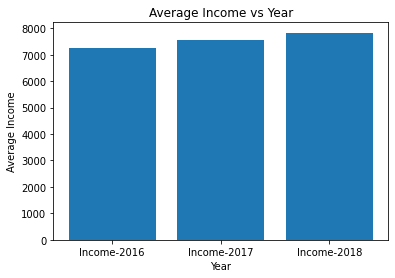

In [15]:
yearly_income = cleaned_income_data[['Income-2016','Income-2017','Income-2018']].mean(axis=0)
plt.bar(['Income-2016','Income-2017','Income-2018'],yearly_income)
plt.xlabel('Year')
plt.ylabel('Average Income')
plt.title("Average Income vs Year")

plt.show()

### By Suburb

In [16]:
sampled = cleaned_income_data.sample(n=10, random_state=1)

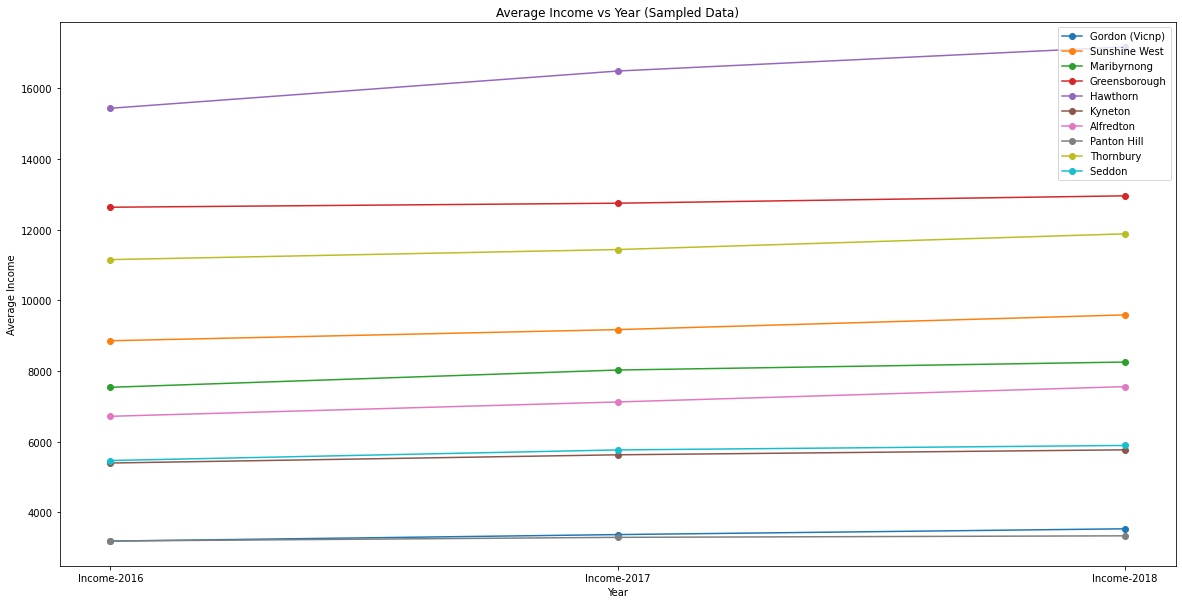

In [17]:
plt.subplots(figsize=(20,10))
for index, row in sampled.iterrows():
    plt.plot(['Income-2016','Income-2017','Income-2018'],row[['Income-2016','Income-2017','Income-2018']],"o-",label = row["Suburb"] )
    
plt.xlabel('Year')
plt.ylabel('Average Income')
plt.title("Average Income vs Year (Sampled Data)")
plt.legend()
plt.show()

### 2.5 Clustering

In [18]:
cleaned_income_data["Income-Mean"] = cleaned_income_data[['Income-2016','Income-2017','Income-2018']].mean(axis=1)

In [19]:
cleaned_income_data

Suburb Income-2016 Income-2017 Income-2018   Income-Mean
0      Abbotsford        5625        6365        6439   6143.000000
1    Airport West        4298        4480        4639   4472.333333
2     Albert Park       10447       11003       11491  10980.333333
3       Alexandra        3564        3644        3735   3647.666667
4       Alfredton        6718        7124        7558   7133.333333
..            ...         ...         ...         ...           ...
418        Yarram        2721        2750        2787   2752.666667
419    Yarraville        9051        9239        9495   9261.666667
420    Yarrawonga        3938        4108        4210   4085.333333
421  Yarriambiack        3416        3600        3602   3539.333333
422           Yea        2003        2041        2097   2047.000000

[417 rows x 5 columns]

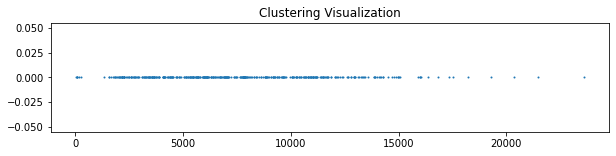

In [368]:
plt.subplots(figsize=(10,2))

plt.scatter(cleaned_income_data["Income-Mean"],[0] * len(cleaned_income_data["Income-Mean"]),1)
    
#plt.xlabel('Mean Income')
#plt.ylabel('2016 Income')
plt.title("Clustering Visualization")
plt.show()

## 2.6 涨幅

In [369]:
cleaned_income_data["IncomeR-16-17"] = (cleaned_income_data["Income-2017"]-cleaned_income_data["Income-2016"])/cleaned_income_data["Income-2016"]
cleaned_income_data["IncomeR-17-18"] = (cleaned_income_data["Income-2018"]-cleaned_income_data["Income-2017"])/cleaned_income_data["Income-2017"]
cleaned_income_data["IncomeR-16-18"] = (cleaned_income_data["Income-2018"]-cleaned_income_data["Income-2016"])/cleaned_income_data["Income-2016"]

In [370]:
cleaned_income_data

Suburb Income-2016 Income-2017 Income-2018   Income-Mean  \
0      Abbotsford        5625        6365        6439   6143.000000   
1    Airport West        4298        4480        4639   4472.333333   
2     Albert Park       10447       11003       11491  10980.333333   
3       Alexandra        3564        3644        3735   3647.666667   
4       Alfredton        6718        7124        7558   7133.333333   
..            ...         ...         ...         ...           ...   
418        Yarram        2721        2750        2787   2752.666667   
419    Yarraville        9051        9239        9495   9261.666667   
420    Yarrawonga        3938        4108        4210   4085.333333   
421  Yarriambiack        3416        3600        3602   3539.333333   
422           Yea        2003        2041        2097   2047.000000   

    IncomeR-16-17 IncomeR-17-18 IncomeR-16-18  
0        0.131556     0.0116261      0.144711  
1       0.0423453     0.0354911     0.0793392  
2        0.053221     0.0443515      0.099933  
3       0.0224467     0.0249726     0.0479798  
4       0.0604347     0.0609208      0.125037  
..            ...           ...           ...  
418     0.0106578     0.0134545     0.0242558  
419     0.0207712     0.0277086     0.0490554  
420     0.0431691     0.0248296     0.0690706  
421     0.0538642   0.000555556     0.0544496  
422     0.0189715     0.0274375     0.0469296  

[417 rows x 8 columns]

In [371]:
top10 = cleaned_income_data.sort_values(by=["IncomeR-16-18"],ascending=False)[:10]

In [372]:
top10

Suburb Income-2016 Income-2017 Income-2018  \
306  Port Melbourne Industrial         133         236         385   
243                 Mickleham         1989        3118        4542   
321                  Rockbank          961         854        2188   
101            Cranbourne East       13256       17511       21261   
410                    Wollert        4483        5750        6636   
116                  Docklands        7337        8957       10207   
302                Point Cook         6471        7939        8924   
29               Beaconsfield         7844        9147       10481   
144      Flemington Racecourse          45          47          59   
379                  Truganina       11666       13583       15094   

      Income-Mean IncomeR-16-17 IncomeR-17-18 IncomeR-16-18  
306    251.333333      0.774436      0.631356       1.89474  
243   3216.333333      0.567622      0.456703       1.28356  
321   1334.333333     -0.111342       1.56206        1.2768  
101  17342.666667      0.320987      0.214151      0.603877  
410   5623.000000      0.282623      0.154087      0.480259  
116   8833.666667      0.220799      0.139556      0.391168  
302   7778.000000      0.226858      0.124071      0.379076  
29    9157.333333      0.166114       0.14584      0.336181  
144     50.333333     0.0444444      0.255319      0.311111  
379  13447.666667      0.164324      0.111242      0.293845

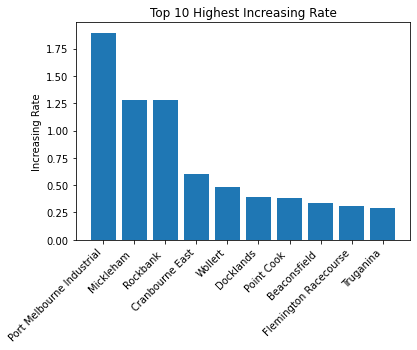

In [373]:
plt.bar(top10["Suburb"], top10["IncomeR-16-18"])

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Increasing Rate')
plt.title('Top 10 Highest Increasing Rate')
plt.xticks(rotation=45,ha='right')


plt.show()

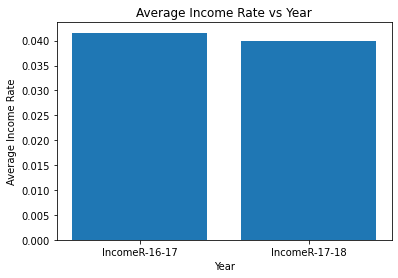

In [374]:
yearly_income = cleaned_income_data[["IncomeR-16-17","IncomeR-17-18"]].mean(axis=0)
plt.bar(["IncomeR-16-17","IncomeR-17-18"],yearly_income)
plt.xlabel('Year')
plt.ylabel('Average Income Rate')
plt.title("Average Income Rate vs Year")

plt.show()

## Top 10 Income

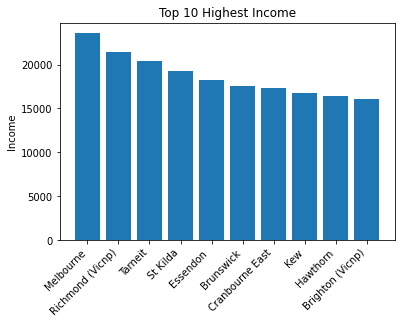

In [22]:
top10 = cleaned_income_data.sort_values(by=["Income-Mean"],ascending=False)[:10]
plt.bar(top10["Suburb"], top10["Income-Mean"])

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Income')
plt.title('Top 10 Highest Income')
plt.xticks(rotation=45,ha='right')


plt.show()

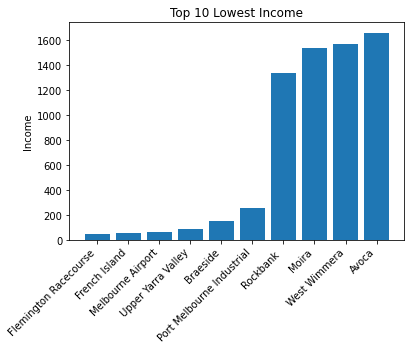

In [23]:
top10 = cleaned_income_data.sort_values(by=["Income-Mean"],ascending=True)[:10]
plt.bar(top10["Suburb"], top10["Income-Mean"])

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Income')
plt.title('Top 10 Lowest Income')
plt.xticks(rotation=45,ha='right')


plt.show()

# 3.House Data

In [375]:
house_full = pd.concat([house1,house2])

In [376]:
house_full.head()

Suburb           Address  Rooms Type      Price Method   SellerG  \
0    Abbotsford     49 Lithgow St      3    h  1490000.0      S    Jellis   
1    Abbotsford     59A Turner St      3    h  1220000.0      S  Marshall   
2    Abbotsford     119B Yarra St      3    h  1420000.0      S    Nelson   
3    Aberfeldie        68 Vida St      3    h  1515000.0      S     Barry   
4  Airport West  92 Clydesdale Rd      2    h   670000.0      S    Nelson   

        Date  Postcode             Regionname  ...  Distance  \
0  1/04/2017    3067.0  Northern Metropolitan  ...       3.0   
1  1/04/2017    3067.0  Northern Metropolitan  ...       3.0   
2  1/04/2017    3067.0  Northern Metropolitan  ...       3.0   
3  1/04/2017    3040.0   Western Metropolitan  ...       7.5   
4  1/04/2017    3042.0   Western Metropolitan  ...      10.4   

                  CouncilArea Bedroom2  Bathroom  Car  Landsize  BuildingArea  \
0          Yarra City Council      NaN       NaN  NaN       NaN           NaN   
1          Yarra City Council      NaN       NaN  NaN       NaN           NaN   
2          Yarra City Council      NaN       NaN  NaN       NaN           NaN   
3  Moonee Valley City Council      NaN       NaN  NaN       NaN           NaN   
4  Moonee Valley City Council      NaN       NaN  NaN       NaN           NaN   

   YearBuilt  Lattitude  Longtitude  
0        NaN        NaN         NaN  
1        NaN        NaN         NaN  
2        NaN        NaN         NaN  
3        NaN        NaN         NaN  
4        NaN        NaN         NaN  

[5 rows x 21 columns]

In [377]:
house_full["Date"] = pd.to_datetime(house_full["Date"])
house_full["Month"] = pd.DatetimeIndex(house_full['Date']).month
house_full["Year"] = pd.DatetimeIndex(house_full['Date']).year
house_full["YM"] = house_full["Year"].astype(str) +"-"+ house_full["Month"].astype(str) 

In [378]:
grouped = house_full.groupby(["YM"])

In [379]:
grouped.describe().sort_values(["YM"]).head()

Rooms                                                 Price  \
          count      mean       std  min  25%  50%  75%   max   count   
YM                                                                      
2016-1     20.0  3.700000  0.978721  2.0  3.0  4.0  4.0   6.0    12.0   
2016-10  3604.0  3.038013  0.998721  1.0  2.0  3.0  4.0  10.0  2791.0   
2016-11  2691.0  3.088071  0.997418  1.0  2.0  3.0  4.0  10.0  2112.0   
2016-12  1449.0  3.013112  0.955773  1.0  2.0  3.0  4.0   6.0  1135.0   
2016-3   2100.0  3.055714  0.964961  1.0  2.0  3.0  4.0   7.0  1643.0   

                       ... Month          Year                               \
                 mean  ...   75%   max   count    mean  std     min     25%   
YM                     ...                                                    
2016-1   8.275000e+05  ...   1.0   1.0    20.0  2016.0  0.0  2016.0  2016.0   
2016-10  1.058173e+06  ...  10.0  10.0  3604.0  2016.0  0.0  2016.0  2016.0   
2016-11  1.083704e+06  ...  11.0  11.0  2691.0  2016.0  0.0  2016.0  2016.0   
2016-12  1.017565e+06  ...  12.0  12.0  1449.0  2016.0  0.0  2016.0  2016.0   
2016-3   1.105092e+06  ...   3.0   3.0  2100.0  2016.0  0.0  2016.0  2016.0   

                                 
            50%     75%     max  
YM                               
2016-1   2016.0  2016.0  2016.0  
2016-10  2016.0  2016.0  2016.0  
2016-11  2016.0  2016.0  2016.0  
2016-12  2016.0  2016.0  2016.0  
2016-3   2016.0  2016.0  2016.0  

[5 rows x 120 columns]

In [380]:
#house_full["Cleaned_Suburb"] = house_full.apply(lambda row: row["Suburb"].split(" ")[0] if row["Suburb"].split(" ")[-1] in ["North","South","West","East"] else row["Suburb"],axis = 1)
#house_sub = set(house_full["Cleaned_Suburb"].values)
#len(house_sub.intersection(income_sub))

只有157个Sub是在两个Dataset中存在的

## 3.1 Data Cleanning

In [381]:
house_full.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Postcode', 'Regionname', 'Propertycount', 'Distance',
       'CouncilArea', 'Bedroom2', 'Bathroom', 'Car', 'Landsize',
       'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Month', 'Year',
       'YM'],
      dtype='object')

In [382]:
house_full = house_full.drop(columns=['Rooms','Method', 'SellerG', 'Lattitude', 'Longtitude',"Distance"])

In [383]:
house_full

Suburb           Address Type      Price       Date  Postcode  \
0        Abbotsford     49 Lithgow St    h  1490000.0 2017-01-04    3067.0   
1        Abbotsford     59A Turner St    h  1220000.0 2017-01-04    3067.0   
2        Abbotsford     119B Yarra St    h  1420000.0 2017-01-04    3067.0   
3        Aberfeldie        68 Vida St    h  1515000.0 2017-01-04    3040.0   
4      Airport West  92 Clydesdale Rd    h   670000.0 2017-01-04    3042.0   
...             ...               ...  ...        ...        ...       ...   
34852    Yarraville       13 Burns St    h  1480000.0 2018-02-24    3013.0   
34853    Yarraville     29A Murray St    h   888000.0 2018-02-24    3013.0   
34854    Yarraville    147A Severn St    t   705000.0 2018-02-24    3013.0   
34855    Yarraville  12/37 Stephen St    h  1140000.0 2018-02-24    3013.0   
34856    Yarraville  3 Tarrengower St    h  1020000.0 2018-02-24    3013.0   

                  Regionname  Propertycount                 CouncilArea  \
0      Northern Metropolitan         4019.0          Yarra City Council   
1      Northern Metropolitan         4019.0          Yarra City Council   
2      Northern Metropolitan         4019.0          Yarra City Council   
3       Western Metropolitan         1543.0  Moonee Valley City Council   
4       Western Metropolitan         3464.0  Moonee Valley City Council   
...                      ...            ...                         ...   
34852   Western Metropolitan         6543.0    Maribyrnong City Council   
34853   Western Metropolitan         6543.0    Maribyrnong City Council   
34854   Western Metropolitan         6543.0    Maribyrnong City Council   
34855   Western Metropolitan         6543.0    Maribyrnong City Council   
34856   Western Metropolitan         6543.0    Maribyrnong City Council   

       Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt  Month  \
0           NaN       NaN  NaN       NaN           NaN        NaN      1   
1           NaN       NaN  NaN       NaN           NaN        NaN      1   
2           NaN       NaN  NaN       NaN           NaN        NaN      1   
3           NaN       NaN  NaN       NaN           NaN        NaN      1   
4           NaN       NaN  NaN       NaN           NaN        NaN      1   
...         ...       ...  ...       ...           ...        ...    ...   
34852       4.0       1.0  3.0     593.0           NaN        NaN      2   
34853       2.0       2.0  1.0      98.0         104.0     2018.0      2   
34854       2.0       1.0  2.0     220.0         120.0     2000.0      2   
34855       NaN       NaN  NaN       NaN           NaN        NaN      2   
34856       2.0       1.0  0.0     250.0         103.0     1930.0      2   

       Year      YM  
0      2017  2017-1  
1      2017  2017-1  
2      2017  2017-1  
3      2017  2017-1  
4      2017  2017-1  
...     ...     ...  
34852  2018  2018-2  
34853  2018  2018-2  
34854  2018  2018-2  
34855  2018  2018-2  
34856  2018  2018-2  

[97880 rows x 18 columns]

In [384]:
# Repalce Na value 
house_full = house_full[house_full["Type"]=="h"]
house_full = house_full[house_full["Price"].notna()]

In [385]:
house_full

Suburb           Address Type      Price       Date  Postcode  \
0        Abbotsford     49 Lithgow St    h  1490000.0 2017-01-04    3067.0   
1        Abbotsford     59A Turner St    h  1220000.0 2017-01-04    3067.0   
2        Abbotsford     119B Yarra St    h  1420000.0 2017-01-04    3067.0   
3        Aberfeldie        68 Vida St    h  1515000.0 2017-01-04    3040.0   
4      Airport West  92 Clydesdale Rd    h   670000.0 2017-01-04    3042.0   
...             ...               ...  ...        ...        ...       ...   
34851    Yarraville     78 Bayview Rd    h  1101000.0 2018-02-24    3013.0   
34852    Yarraville       13 Burns St    h  1480000.0 2018-02-24    3013.0   
34853    Yarraville     29A Murray St    h   888000.0 2018-02-24    3013.0   
34855    Yarraville  12/37 Stephen St    h  1140000.0 2018-02-24    3013.0   
34856    Yarraville  3 Tarrengower St    h  1020000.0 2018-02-24    3013.0   

                  Regionname  Propertycount                 CouncilArea  \
0      Northern Metropolitan         4019.0          Yarra City Council   
1      Northern Metropolitan         4019.0          Yarra City Council   
2      Northern Metropolitan         4019.0          Yarra City Council   
3       Western Metropolitan         1543.0  Moonee Valley City Council   
4       Western Metropolitan         3464.0  Moonee Valley City Council   
...                      ...            ...                         ...   
34851   Western Metropolitan         6543.0    Maribyrnong City Council   
34852   Western Metropolitan         6543.0    Maribyrnong City Council   
34853   Western Metropolitan         6543.0    Maribyrnong City Council   
34855   Western Metropolitan         6543.0    Maribyrnong City Council   
34856   Western Metropolitan         6543.0    Maribyrnong City Council   

       Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt  Month  \
0           NaN       NaN  NaN       NaN           NaN        NaN      1   
1           NaN       NaN  NaN       NaN           NaN        NaN      1   
2           NaN       NaN  NaN       NaN           NaN        NaN      1   
3           NaN       NaN  NaN       NaN           NaN        NaN      1   
4           NaN       NaN  NaN       NaN           NaN        NaN      1   
...         ...       ...  ...       ...           ...        ...    ...   
34851       3.0       1.0  NaN     288.0           NaN        NaN      2   
34852       4.0       1.0  3.0     593.0           NaN        NaN      2   
34853       2.0       2.0  1.0      98.0         104.0     2018.0      2   
34855       NaN       NaN  NaN       NaN           NaN        NaN      2   
34856       2.0       1.0  0.0     250.0         103.0     1930.0      2   

       Year      YM  
0      2017  2017-1  
1      2017  2017-1  
2      2017  2017-1  
3      2017  2017-1  
4      2017  2017-1  
...     ...     ...  
34851  2018  2018-2  
34852  2018  2018-2  
34853  2018  2018-2  
34855  2018  2018-2  
34856  2018  2018-2  

[52633 rows x 18 columns]

## 3.2 Visualization

In [386]:
house_full["Price"].describe()

count    5.263300e+04
mean     1.143272e+06
std      6.573909e+05
min      1.310000e+05
25%      7.050000e+05
50%      9.600000e+05
75%      1.385000e+06
max      1.120000e+07
Name: Price, dtype: float64

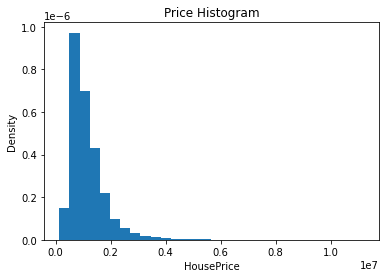

In [387]:
plt.hist(house_full["Price"], 30, density=True)
plt.xlabel('HousePrice')
plt.ylabel('Density')
plt.title("Price Histogram")

# Tweak spacing to prevent clipping of ylabel
plt.show()

## 3.3 Z-score remove outliers

In [388]:
from scipy import stats
import numpy as np

In [389]:
removed_house_full = house_full[(np.abs(stats.zscore(house_full["Price"])) < 3)]
removed_house_full.head()

Suburb           Address Type      Price       Date  Postcode  \
0    Abbotsford     49 Lithgow St    h  1490000.0 2017-01-04    3067.0   
1    Abbotsford     59A Turner St    h  1220000.0 2017-01-04    3067.0   
2    Abbotsford     119B Yarra St    h  1420000.0 2017-01-04    3067.0   
3    Aberfeldie        68 Vida St    h  1515000.0 2017-01-04    3040.0   
4  Airport West  92 Clydesdale Rd    h   670000.0 2017-01-04    3042.0   

              Regionname  Propertycount                 CouncilArea  Bedroom2  \
0  Northern Metropolitan         4019.0          Yarra City Council       NaN   
1  Northern Metropolitan         4019.0          Yarra City Council       NaN   
2  Northern Metropolitan         4019.0          Yarra City Council       NaN   
3   Western Metropolitan         1543.0  Moonee Valley City Council       NaN   
4   Western Metropolitan         3464.0  Moonee Valley City Council       NaN   

   Bathroom  Car  Landsize  BuildingArea  YearBuilt  Month  Year      YM  
0       NaN  NaN       NaN           NaN        NaN      1  2017  2017-1  
1       NaN  NaN       NaN           NaN        NaN      1  2017  2017-1  
2       NaN  NaN       NaN           NaN        NaN      1  2017  2017-1  
3       NaN  NaN       NaN           NaN        NaN      1  2017  2017-1  
4       NaN  NaN       NaN           NaN        NaN      1  2017  2017-1

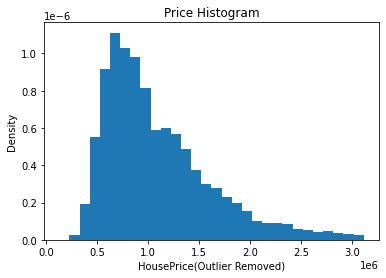

In [390]:
plt.hist(removed_house_full["Price"], 30, density=True)
plt.xlabel('HousePrice(Outlier Removed)')
plt.ylabel('Density')
plt.title("Price Histogram")

# Tweak spacing to prevent clipping of ylabel
plt.show()

In [391]:
yearly_house = removed_house_full.groupby(by="Year").describe()["Price"]["mean"]

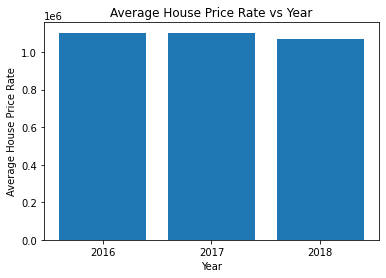

In [392]:
yearly_houseprice = yearly_house
plt.bar(yearly_house.index,yearly_houseprice)


plt.xlabel('Year')
plt.xticks(yearly_house.index)
plt.ylabel('Average House Price Rate')
plt.title("Average House Price Rate vs Year")

plt.show()

## 3.4 Grouping By Suburb
find the most expensive and cheap sub

In [393]:
removed_grouped = removed_house_full.groupby("Suburb").describe()

In [394]:
top10_expensive = removed_grouped["Price"]["mean"].sort_values(ascending=False)[:10]
top10_expensive_label = removed_grouped["Price"]["mean"].sort_values(ascending=False).index[:10]
top10_cheap = removed_grouped["Price"]["mean"].sort_values(ascending=True)[:10]
top10_cheap_label = removed_grouped["Price"]["mean"].sort_values(ascending=True).index[:10]

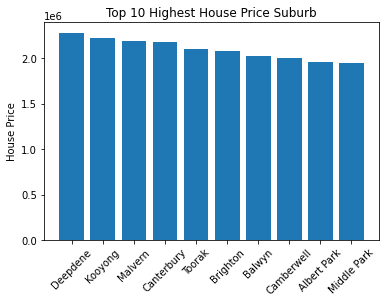

In [395]:
plt.bar(top10_expensive_label, top10_expensive)

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('House Price')
plt.title('Top 10 Highest House Price Suburb')
plt.xticks(rotation=45)


plt.show()

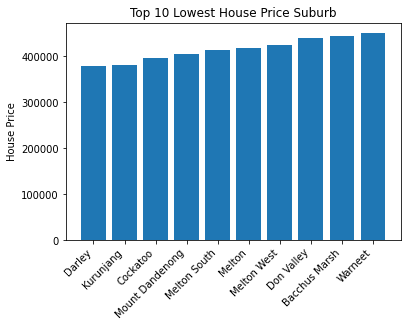

In [396]:
plt.bar(top10_cheap_label, top10_cheap)

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('House Price')
plt.title('Top 10 Lowest House Price Suburb')
plt.xticks(rotation=45,ha='right')

fig.tight_layout()

plt.show()

## 3.5 House features Visualization 

In [397]:
house_feature = house_full[house_full["Bedroom2"].notna() & 
                           house_full["Bathroom"].notna()& 
                           house_full["Car"].notna() & 
                           house_full["Landsize"].notna()& 
                           house_full["BuildingArea"].notna() & 
                           house_full["YearBuilt"].notna()]

In [398]:
print(house_feature["Bedroom2"].describe())
print("++++++")
print(house_feature["Bathroom"].describe())
print("++++++")
print(house_feature["Car"].describe())
print("++++++")
print(house_feature["Landsize"].describe())
print("++++++")
print(house_feature["BuildingArea"].describe())
print("++++++")
print(house_feature["YearBuilt"].describe())

count    6628.000000
mean        3.365118
std         0.854109
min         0.000000
25%         3.000000
50%         3.000000
75%         4.000000
max        12.000000
Name: Bedroom2, dtype: float64
++++++
count    6628.000000
mean        1.733404
std         0.747807
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         9.000000
Name: Bathroom, dtype: float64
++++++
count    6628.000000
mean        1.837508
std         1.043493
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        10.000000
Name: Car, dtype: float64
++++++
count     6628.000000
mean       565.362855
std        881.761304
min          0.000000
25%        353.000000
50%        561.000000
75%        672.000000
max      42800.000000
Name: Landsize, dtype: float64
++++++
count    6628.000000
mean      166.837744
std        89.835663
min         0.000000
25%       115.000000
50%       147.000000
75%       196.000000
max      3112.000000
Name:

In [399]:
house_feature_reduced = house_feature[["Price","Bedroom2","Bathroom","Car","Landsize","BuildingArea","YearBuilt","Suburb"]]

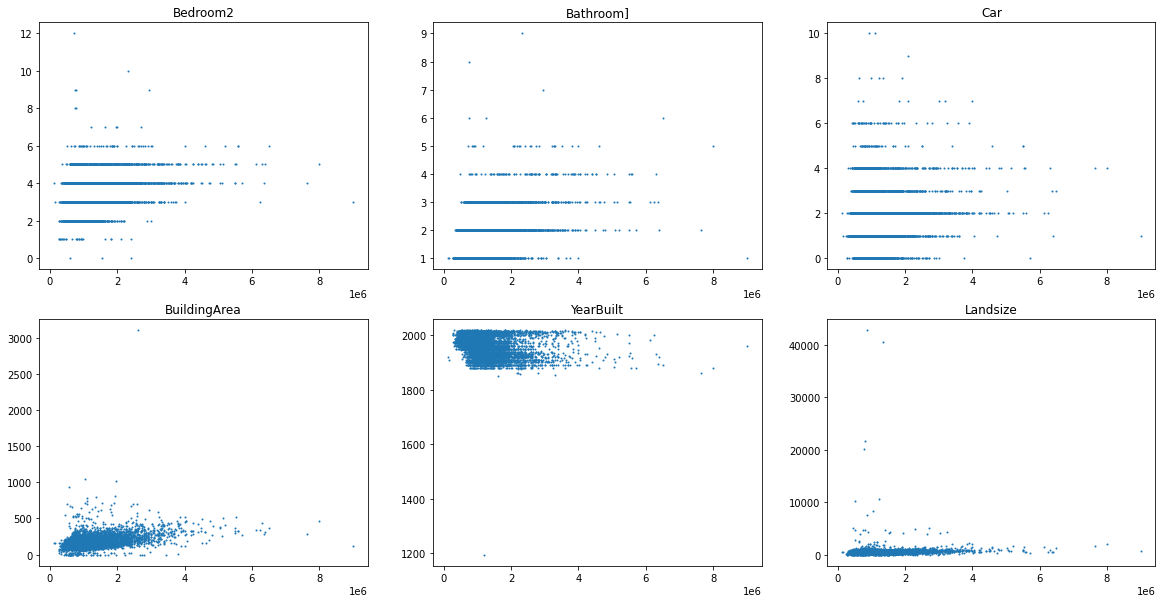

In [400]:
fig, axs = plt.subplots(2, 3,figsize = (20,10))
axs[0, 0].scatter(house_feature_reduced["Price"],house_feature_reduced["Bedroom2"],1)
axs[0, 0].set_title('Bedroom2')
axs[0, 1].scatter(house_feature_reduced["Price"],house_feature_reduced["Bathroom"],1)
axs[0, 1].set_title('Bathroom]')
axs[0, 2].scatter(house_feature_reduced["Price"], house_feature_reduced["Car"],1)
axs[0, 2].set_title('Car')
axs[1, 0].scatter(house_feature_reduced["Price"],house_feature_reduced["BuildingArea"],1)
axs[1, 0].set_title('BuildingArea')
axs[1, 1].scatter(house_feature_reduced["Price"],house_feature_reduced["YearBuilt"],1)
axs[1, 1].set_title('YearBuilt')
axs[1, 2].scatter(house_feature_reduced["Price"], house_feature_reduced["Landsize"],1)
axs[1, 2].set_title('Landsize')
# axs[1, 2].scatter(house_feature_reduced["Price"], house_feature_reduced["Suburb"])
# axs[1, 2].set_title('Suburb')



plt.show()

## Correlation

In [401]:
house_feature_reduced.corr()

Price  Bedroom2  Bathroom       Car  Landsize  BuildingArea  \
Price         1.000000  0.325842  0.412554  0.107952  0.050908      0.431125   
Bedroom2      0.325842  1.000000  0.615481  0.312245  0.138467      0.511985   
Bathroom      0.412554  0.615481  1.000000  0.252526  0.088863      0.525982   
Car           0.107952  0.312245  0.252526  1.000000  0.157703      0.239981   
Landsize      0.050908  0.138467  0.088863  0.157703  1.000000      0.102339   
BuildingArea  0.431125  0.511985  0.525982  0.239981  0.102339      1.000000   
YearBuilt    -0.268341  0.211757  0.264231  0.241867  0.081449      0.186021   

              YearBuilt  
Price         -0.268341  
Bedroom2       0.211757  
Bathroom       0.264231  
Car            0.241867  
Landsize       0.081449  
BuildingArea   0.186021  
YearBuilt      1.000000

In [402]:
house_feature_reduced

Price  Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt  \
2      1035000.0       2.0       1.0  0.0     156.0          79.0     1900.0   
4      1465000.0       3.0       2.0  0.0     134.0         150.0     1900.0   
6      1600000.0       3.0       1.0  2.0     120.0         142.0     2014.0   
11     1876000.0       4.0       2.0  0.0     245.0         210.0     1910.0   
14     1636000.0       2.0       1.0  2.0     256.0         107.0     1890.0   
...          ...       ...       ...  ...       ...           ...        ...   
34837  2020000.0       5.0       3.0  2.0     450.0         241.0     2015.0   
34847   500000.0       3.0       2.0  2.0     383.0         118.0     2016.0   
34849   570000.0       3.0       2.0  2.0     404.0         158.0     2012.0   
34853   888000.0       2.0       2.0  1.0      98.0         104.0     2018.0   
34856  1020000.0       2.0       1.0  0.0     250.0         103.0     1930.0   

             Suburb  
2        Abbotsford  
4        Abbotsford  
6        Abbotsford  
11       Abbotsford  
14       Abbotsford  
...             ...  
34837  Williamstown  
34847       Wollert  
34849       Wollert  
34853    Yarraville  
34856    Yarraville  

[6628 rows x 8 columns]

In [403]:
#https://wil.yegelwel.com/cluster-correlation-matrix/

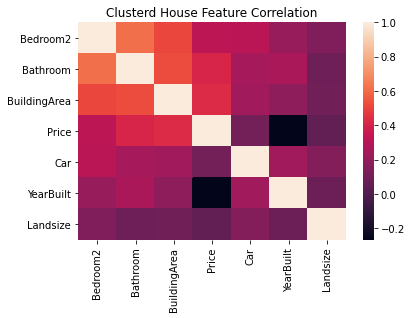

In [404]:
sns.heatmap(cluster_corr(house_feature_reduced.corr()))
plt.title("Clusterd House Feature Correlation")
plt.show()

## 4.Combined Income and House Price

In [405]:
removed_house_full

Suburb           Address Type      Price       Date  Postcode  \
0        Abbotsford     49 Lithgow St    h  1490000.0 2017-01-04    3067.0   
1        Abbotsford     59A Turner St    h  1220000.0 2017-01-04    3067.0   
2        Abbotsford     119B Yarra St    h  1420000.0 2017-01-04    3067.0   
3        Aberfeldie        68 Vida St    h  1515000.0 2017-01-04    3040.0   
4      Airport West  92 Clydesdale Rd    h   670000.0 2017-01-04    3042.0   
...             ...               ...  ...        ...        ...       ...   
34851    Yarraville     78 Bayview Rd    h  1101000.0 2018-02-24    3013.0   
34852    Yarraville       13 Burns St    h  1480000.0 2018-02-24    3013.0   
34853    Yarraville     29A Murray St    h   888000.0 2018-02-24    3013.0   
34855    Yarraville  12/37 Stephen St    h  1140000.0 2018-02-24    3013.0   
34856    Yarraville  3 Tarrengower St    h  1020000.0 2018-02-24    3013.0   

                  Regionname  Propertycount                 CouncilArea  \
0      Northern Metropolitan         4019.0          Yarra City Council   
1      Northern Metropolitan         4019.0          Yarra City Council   
2      Northern Metropolitan         4019.0          Yarra City Council   
3       Western Metropolitan         1543.0  Moonee Valley City Council   
4       Western Metropolitan         3464.0  Moonee Valley City Council   
...                      ...            ...                         ...   
34851   Western Metropolitan         6543.0    Maribyrnong City Council   
34852   Western Metropolitan         6543.0    Maribyrnong City Council   
34853   Western Metropolitan         6543.0    Maribyrnong City Council   
34855   Western Metropolitan         6543.0    Maribyrnong City Council   
34856   Western Metropolitan         6543.0    Maribyrnong City Council   

       Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt  Month  \
0           NaN       NaN  NaN       NaN           NaN        NaN      1   
1           NaN       NaN  NaN       NaN           NaN        NaN      1   
2           NaN       NaN  NaN       NaN           NaN        NaN      1   
3           NaN       NaN  NaN       NaN           NaN        NaN      1   
4           NaN       NaN  NaN       NaN           NaN        NaN      1   
...         ...       ...  ...       ...           ...        ...    ...   
34851       3.0       1.0  NaN     288.0           NaN        NaN      2   
34852       4.0       1.0  3.0     593.0           NaN        NaN      2   
34853       2.0       2.0  1.0      98.0         104.0     2018.0      2   
34855       NaN       NaN  NaN       NaN           NaN        NaN      2   
34856       2.0       1.0  0.0     250.0         103.0     1930.0      2   

       Year      YM  
0      2017  2017-1  
1      2017  2017-1  
2      2017  2017-1  
3      2017  2017-1  
4      2017  2017-1  
...     ...     ...  
34851  2018  2018-2  
34852  2018  2018-2  
34853  2018  2018-2  
34855  2018  2018-2  
34856  2018  2018-2  

[51738 rows x 18 columns]

In [406]:
merged= pd.merge(removed_house_full, cleaned_income_data, on='Suburb')

In [407]:
incomelist = []
for index, row in merged.iterrows():
    year = "Income-"+str(row["Year"])
    incomelist.append(row[year])

In [408]:
merged["Income"] = incomelist

In [409]:
merged.head()

Suburb           Address Type      Price       Date  Postcode  \
0  Abbotsford     49 Lithgow St    h  1490000.0 2017-01-04    3067.0   
1  Abbotsford     59A Turner St    h  1220000.0 2017-01-04    3067.0   
2  Abbotsford     119B Yarra St    h  1420000.0 2017-01-04    3067.0   
3  Abbotsford  256 Langridge St    h  1350000.0 2017-01-07    3067.0   
4  Abbotsford      85 Turner St    h  1480000.0 2016-03-12    3067.0   

              Regionname  Propertycount         CouncilArea  Bedroom2  ...  \
0  Northern Metropolitan         4019.0  Yarra City Council       NaN  ...   
1  Northern Metropolitan         4019.0  Yarra City Council       NaN  ...   
2  Northern Metropolitan         4019.0  Yarra City Council       NaN  ...   
3  Northern Metropolitan         4019.0  Yarra City Council       NaN  ...   
4  Northern Metropolitan         4019.0  Yarra City Council       NaN  ...   

   Year      YM  Income-2016  Income-2017  Income-2018  Income-Mean  \
0  2017  2017-1         5625         6365         6439       6143.0   
1  2017  2017-1         5625         6365         6439       6143.0   
2  2017  2017-1         5625         6365         6439       6143.0   
3  2017  2017-1         5625         6365         6439       6143.0   
4  2016  2016-3         5625         6365         6439       6143.0   

   IncomeR-16-17 IncomeR-17-18 IncomeR-16-18 Income  
0       0.131556     0.0116261      0.144711   6365  
1       0.131556     0.0116261      0.144711   6365  
2       0.131556     0.0116261      0.144711   6365  
3       0.131556     0.0116261      0.144711   6365  
4       0.131556     0.0116261      0.144711   5625  

[5 rows x 26 columns]

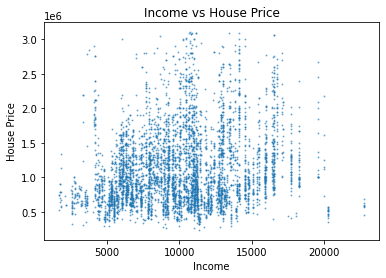

In [410]:
sampled = merged.sample(n=5000, random_state=1)

#plt.subplots(figsize = (20,10))
plt.scatter(sampled["Income"],sampled["Price"],1,alpha = 0.5)
#plt.scatter(merged["Price"],merged["Mean"],2,alpha = 0.5,label = "Mean")
plt.ylabel('House Price')
plt.xlabel('Income')
plt.title("Income vs House Price")

plt.show()

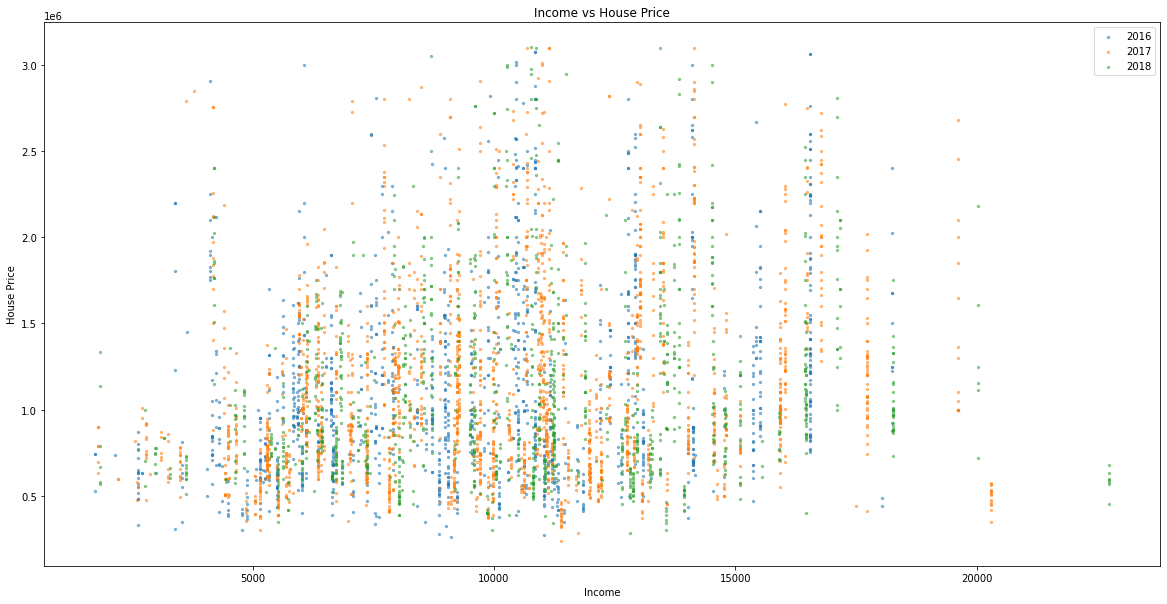

In [411]:
sample_2016 = sampled[sampled["Year"] == 2016]
sample_2017 = sampled[sampled["Year"] == 2017]
sample_2018 = sampled[sampled["Year"] == 2018]

plt.subplots(figsize = (20,10))
plt.scatter(sample_2016["Income"],sample_2016["Price"],5,alpha = 0.5,label = "2016")
plt.scatter(sample_2017["Income"],sample_2017["Price"],5,alpha = 0.5,label = "2017")
plt.scatter(sample_2018["Income"],sample_2018["Price"],5,alpha = 0.5,label = "2018")
#plt.scatter(merged["Price"],merged["Mean"],2,alpha = 0.5,label = "Mean")
plt.ylabel('House Price')
plt.xlabel('Income')
plt.title("Income vs House Price")
plt.legend()
plt.show()

In [412]:
sampled[["Income","Price"]].corr()

Income     Price
Income  1.000000  0.198979
Price   0.198979  1.000000

# 5. 强做房价

In [413]:
house_price = removed_house_full.groupby("Suburb").describe()["Price"]["mean"]

In [414]:
house_price = pd.DataFrame(house_price)

In [415]:
merged2= pd.merge(house_price, cleaned_income_data, on='Suburb')

In [416]:
merged2

Suburb          mean Income-2016 Income-2017 Income-2018  \
0        Abbotsford  1.221714e+06        5625        6365        6439   
1      Airport West  8.326442e+05        4298        4480        4639   
2       Albert Park  1.955922e+06       10447       11003       11491   
3            Altona  1.005401e+06        7610        7910        7942   
4    Altona Meadows  6.640309e+05       10578       10722       10827   
..              ...           ...         ...         ...         ...   
150      Whittlesea  5.292000e+05        4375        4511        4724   
151    Williamstown  1.491425e+06        9534        9706        9996   
152         Wollert  5.901921e+05        4483        5750        6636   
153    Wyndham Vale  4.887228e+05       11446       13064       13931   
154      Yarraville  1.082441e+06        9051        9239        9495   

      Income-Mean IncomeR-16-17 IncomeR-17-18 IncomeR-16-18  
0     6143.000000      0.131556     0.0116261      0.144711  
1     4472.333333     0.0423453     0.0354911     0.0793392  
2    10980.333333      0.053221     0.0443515      0.099933  
3     7820.666667     0.0394218    0.00404551     0.0436268  
4    10709.000000     0.0136132    0.00979295     0.0235394  
..            ...           ...           ...           ...  
150   4536.666667     0.0310857     0.0472179     0.0797714  
151   9745.333333     0.0180407     0.0298784     0.0484581  
152   5623.000000      0.282623      0.154087      0.480259  
153  12813.666667      0.141359     0.0663656      0.217106  
154   9261.666667     0.0207712     0.0277086     0.0490554  

[155 rows x 9 columns]

In [417]:
merged2[["mean","Income-2016","Income-2017","Income-2018"]] = merged2[["mean","Income-2016","Income-2017","Income-2018"]].astype('float')

In [418]:
merged2[["mean","Income-2016","Income-2017","Income-2018"]].corr()

mean  Income-2016  Income-2017  Income-2018
mean         1.000000     0.221222     0.209010     0.172334
Income-2016  0.221222     1.000000     0.988579     0.980445
Income-2017  0.209010     0.988579     1.000000     0.991572
Income-2018  0.172334     0.980445     0.991572     1.000000

-----

## House By year and Sub

In [419]:
house_price_year = removed_house_full.groupby(["Suburb","Year"]).describe()
house_price_year = pd.DataFrame(house_price_year["Price"]["mean"])

In [420]:
house_price_year= house_price_year.reset_index(level=[0,1])
flatten = pd.pivot_table(house_price_year,values=['mean'],index=['Suburb'],columns=['Year'],fill_value=np.nan,margins=False)

In [421]:
flatten.columns = flatten.columns.droplevel(0)

In [422]:
flatten = flatten.rename(columns={2016: 'House-2016', 2017: 'House-2017',2018: 'House-2018'})

In [423]:
flatten["HouseR-16-17"] = (flatten["House-2017"]-flatten["House-2016"])/flatten["House-2016"]
flatten["HouseR-17-18"] = (flatten["House-2018"]-flatten["House-2017"])/flatten["House-2017"]
flatten["HouseR-16-18"] = (flatten["House-2018"]-flatten["House-2016"])/flatten["House-2016"]

In [424]:
flatten

Year              House-2016    House-2017    House-2018  HouseR-16-17  \
Suburb                                                                   
Abbotsford      1.232889e+06  1.222577e+06  1.197093e+06     -0.008364   
Aberfeldie      1.400786e+06  1.605129e+06  1.560000e+06      0.145878   
Airport West    7.971667e+05  8.450957e+05  8.474681e+05      0.060124   
Albanvale       4.400000e+05  5.423684e+05  5.235000e+05      0.232656   
Albert Park     1.813129e+06  2.042170e+06  1.999483e+06      0.126324   
...                      ...           ...           ...           ...   
Yan Yean        1.415000e+06           NaN           NaN           NaN   
Yarra Glen               NaN  6.200000e+05  1.170000e+06           NaN   
Yarra Junction           NaN  4.550000e+05           NaN           NaN   
Yarraville      1.002972e+06  1.107848e+06  1.133799e+06      0.104565   
croydon                  NaN  7.300000e+05           NaN           NaN   

Year            HouseR-17-18  HouseR-16-18  
Suburb                                      
Abbotsford         -0.020845     -0.029034  
Aberfeldie         -0.028116      0.113661  
Airport West        0.002807      0.063100  
Albanvale          -0.034789      0.189773  
Albert Park        -0.020903      0.102780  
...                      ...           ...  
Yan Yean                 NaN           NaN  
Yarra Glen          0.887097           NaN  
Yarra Junction           NaN           NaN  
Yarraville          0.023425      0.130439  
croydon                  NaN           NaN  

[369 rows x 6 columns]

In [425]:
merged3= pd.merge(flatten, cleaned_income_data, on='Suburb')

merged3 = merged3.dropna()

In [426]:
merged3["HouseR-16-18"].describe()

count    145.000000
mean       0.142543
std        0.151653
min       -0.133905
25%        0.048741
50%        0.120991
75%        0.190539
max        0.861176
Name: HouseR-16-18, dtype: float64

In [427]:
merged3[["IncomeR-16-18","Income-2016","Income-2017","Income-2018"]] = merged3[["IncomeR-16-18","Income-2016","Income-2017","Income-2018"]].astype('float')
merged3["IncomeR-16-18"].describe()

count    145.000000
mean       0.090039
std        0.078154
min        0.000815
25%        0.042888
50%        0.068955
75%        0.112900
max        0.603877
Name: IncomeR-16-18, dtype: float64

In [428]:
top10_House = merged3.sort_values(by = ["HouseR-16-18","IncomeR-16-18"],ascending=False)[:10]
top10_Income = merged3.sort_values(by = ["IncomeR-16-18","HouseR-16-18",],ascending=False)[:10]

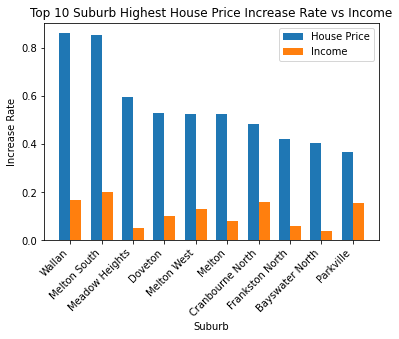

In [429]:

labels = top10_House["Suburb"]
HouseR = top10_House["HouseR-16-18"]
IncomeR = top10_House["IncomeR-16-18"]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, HouseR, width, label='House Price')
rects2 = ax.bar(x + width/2, IncomeR, width, label='Income')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation = 45, ha="right")

ax.set_ylabel('Increase Rate')
ax.set_xlabel('Suburb')
ax.set_title('Top 10 Suburb Highest House Price Increase Rate vs Income')
ax.legend()



plt.show()

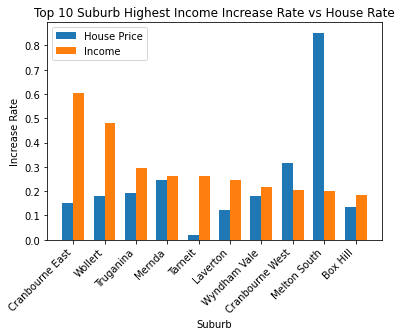

In [430]:
labels = top10_Income["Suburb"]
HouseR = top10_Income["HouseR-16-18"]
IncomeR = top10_Income["IncomeR-16-18"]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, HouseR, width, label='House Price')
rects2 = ax.bar(x + width/2, IncomeR, width, label='Income')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation = 45, ha="right")

ax.set_ylabel('Increase Rate')
ax.set_xlabel('Suburb')
ax.set_title('Top 10 Suburb Highest Income Increase Rate vs House Rate')
ax.legend()

plt.show()
